In [4]:
neurons = 64
layers = 6
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN([1] + [neurons] * layers + [2], activation, initializer)

model = dde.Model(data, net)

In [5]:
model.compile("adam", lr=0.001)
losshistory, train_state = model.train(iterations=10000, display_every=2000)

Compiling model...
'compile' took 6.787352 s

Training model...

Step      Train loss                                  Test loss                                   Test metric
0         [1.71e-02, 8.42e-03, 1.44e+00, 6.40e-01]    [1.71e-02, 8.42e-03, 1.44e+00, 6.40e-01]    []  
2000      [2.01e-04, 6.10e-04, 2.47e-07, 4.12e-06]    [2.01e-04, 6.10e-04, 2.47e-07, 4.12e-06]    []  
4000      [6.04e-05, 6.77e-05, 1.95e-05, 4.70e-08]    [6.04e-05, 6.77e-05, 1.95e-05, 4.70e-08]    []  
6000      [2.46e-05, 8.76e-06, 1.12e-06, 2.33e-07]    [2.46e-05, 8.76e-06, 1.12e-06, 2.33e-07]    []  
8000      [2.63e-06, 1.02e-06, 6.87e-07, 9.75e-10]    [2.63e-06, 1.02e-06, 6.87e-07, 9.75e-10]    []  
10000     [3.10e-06, 1.50e-06, 2.21e-06, 3.11e-10]    [3.10e-06, 1.50e-06, 2.21e-06, 3.11e-10]    []  

Best model at step 8000:
  train loss: 4.34e-06
  test loss: 4.34e-06
  test metric: []

'train' took 210.774804 s



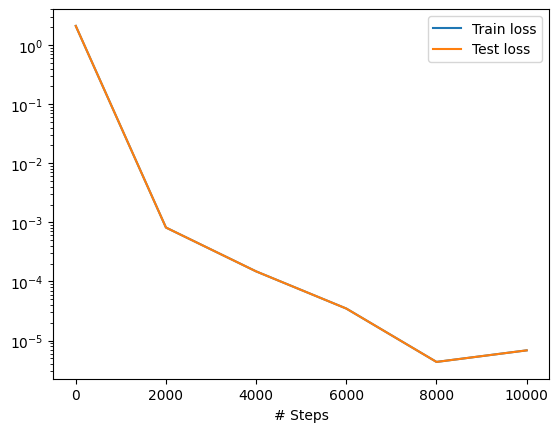

In [6]:
dde.utils.external.plot_loss_history(losshistory)

In [7]:
def runge_kutta(
    t,
    x0,
    y0,
    alpha,
    beta,
    gamma,
    delta
):

    def func(t, Y):
        x, y = Y
        dx_dt = alpha * x - beta * x * y
        dy_dt = - gamma * y  + delta * x * y
        return dx_dt, dy_dt

    Y0 = [x0, y0]
    t_span = (t[0], t[-1])
    sol = solve_ivp(func, t_span, Y0, t_eval=t)
    x_true, y_true = sol.y
    return x_true, y_true
t_array = np.linspace(t_initial, t_final, 100)
x_rungekutta, y_rungekutta = runge_kutta(t_array, x0, y0, alpha, beta, gamma, delta)

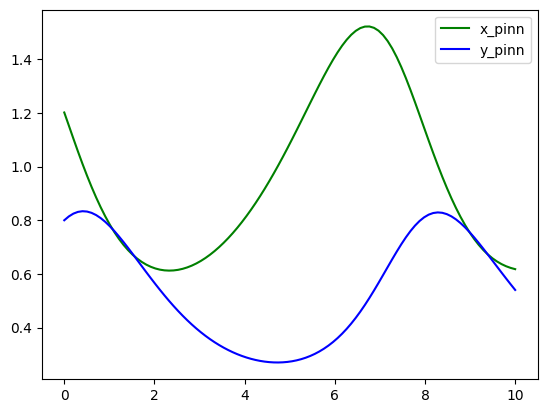

In [8]:
pinn_pred = model.predict(t_array.reshape(-1, 1))
x_pinn = pinn_pred[:, 0:1]
y_pinn = pinn_pred[:, 1:2]

plt.plot(t_array, x_pinn, color="green", label="x_pinn")
plt.plot(t_array, y_pinn, color="blue", label="y_pinn")
plt.legend()
plt.show()

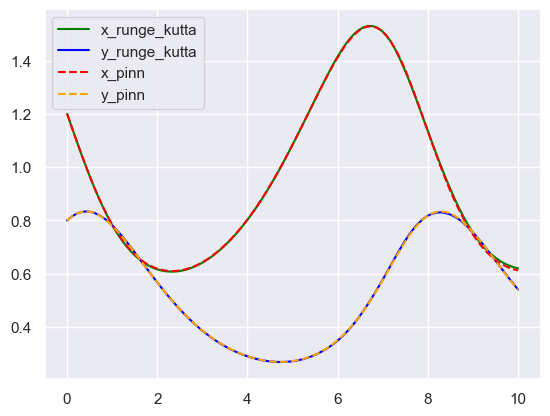

In [161]:
plt.plot(t_array, x_rungekutta, color="green", label="x_runge_kutta")
plt.plot(t_array, y_rungekutta, color="blue", label="y_runge_kutta")
plt.plot(t_array, x_pinn, color="red", linestyle="dashed", label="x_pinn")
plt.plot(t_array, y_pinn, color="orange", linestyle="dashed", label="y_pinn")
plt.legend()
plt.show()

In [162]:
t_initial, t_final = 0, 10  # Equivalent to 10 days
x0 = 1.2
y0 = 0.8

alpha_real = 2 / 3
beta_real = 4 / 3
gamma_real = 1
delta_real = 1

parameters_real = {
    "alpha": alpha_real,
    "beta": beta_real,
    "gamma": gamma_real,
    "delta": delta_real
}  # We will use this later for study errors

In [111]:
def generate_data(
    t,
    x0,
    y0,
    alpha,
    beta,
    gamma,
    delta
):

    def func(t, Y):
        x, y = Y
        dx_dt = alpha * x - beta * x * y
        dy_dt = - gamma * y  + delta * x * y
        return dx_dt, dy_dt

    Y0 = [x0, y0]
    t = t.flatten()
    t_span = (t[0], t[-1])
    sol = solve_ivp(func, t_span, Y0, t_eval=t)
    return sol.y.T

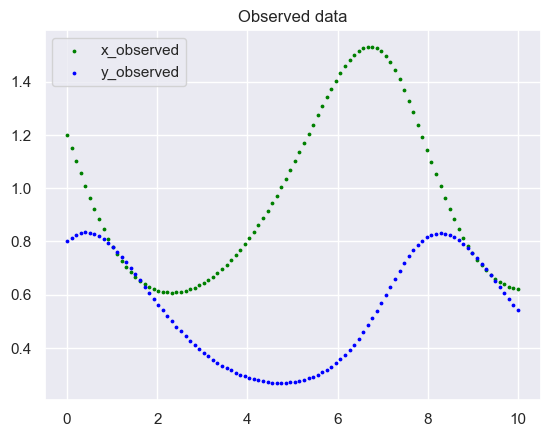

In [112]:
t_train = np.linspace(t_initial, t_final, 100).reshape(-1, 1)
Y_train = generate_data(t_train, x0, y0, alpha_real, beta_real, gamma_real, delta_real)

x_train = Y_train[:, 0:1]
y_train = Y_train[:, 1:2]
plt.scatter(t_train, x_train, color="green", s=3, label="x_observed")
plt.scatter(t_train, y_train, color="blue", s=3, label="y_observed")
plt.legend()
plt.title("Observed data")
plt.show()

In [113]:
# Pick some initial guess

alpha = dde.Variable(0.0)
beta = dde.Variable(0.0)
gamma = dde.Variable(0.0)
delta = dde.Variable(0.0)

In [114]:
def ode(t, Y):
    x = Y[:, 0:1]
    y = Y[:, 1:2]
    dx_dt = dde.grad.jacobian(Y, t, i=0)
    dy_dt = dde.grad.jacobian(Y, t, i=1)
    
    return [
        dx_dt - alpha * x + beta * x * y,
        dy_dt + gamma * y  - delta * x * y
    ]

In [115]:
geom = dde.geometry.TimeDomain(t_initial, t_final)

def boundary(_, on_initial):
    return on_initial

ic_x = dde.icbc.IC(geom, lambda x: x0, boundary, component=0)
ic_y = dde.icbc.IC(geom, lambda x: y0, boundary, component=1)

In [116]:
observe_x = dde.icbc.PointSetBC(t_train.reshape(-1, 1), Y_train[:, 0:1], component=0)
observe_y = dde.icbc.PointSetBC(t_train.reshape(-1, 1), Y_train[:, 1:2], component=1)

data = dde.data.PDE(
    geom,
    ode,
    [ic_x, ic_y, observe_x, observe_y],
    num_domain=512,
    num_boundary=2,
    anchors=t_train,
)

In [117]:
neurons = 64
layers = 6
activation = "tanh"
initializer = "Glorot normal"
net = dde.nn.FNN([1] + [neurons] * layers + [2], activation, initializer)

In [124]:
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=0.001,
    external_trainable_variables=[alpha, beta, gamma, delta]
)

Compiling model...
'compile' took 0.000439 s



In [125]:
variable = dde.callbacks.VariableValue(
    [alpha, beta, gamma, delta],
    period=100,
    filename="variables.dat"
)

Training model...

Step      Train loss                                                      Test loss                                                       Test metric
0         [1.83e-05, 8.72e-06, 5.90e-06, 8.26e-07, 1.39e-05, 4.71e-06]    [1.83e-05, 8.72e-06, 5.90e-06, 8.26e-07, 1.39e-05, 4.71e-06]    []  
5000      [5.24e-06, 3.76e-06, 4.12e-06, 4.85e-07, 4.96e-06, 3.05e-06]    [5.24e-06, 3.76e-06, 4.12e-06, 4.85e-07, 4.96e-06, 3.05e-06]    []  
10000     [1.37e-06, 1.05e-06, 4.00e-08, 3.02e-07, 2.43e-05, 6.11e-06]    [1.37e-06, 1.05e-06, 4.00e-08, 3.02e-07, 2.43e-05, 6.11e-06]    []  
15000     [1.21e-05, 4.74e-06, 2.78e-06, 4.53e-07, 1.50e-06, 5.85e-06]    [1.21e-05, 4.74e-06, 2.78e-06, 4.53e-07, 1.50e-06, 5.85e-06]    []  
20000     [1.26e-06, 1.49e-06, 4.49e-08, 1.66e-08, 1.86e-06, 1.21e-06]    [1.26e-06, 1.49e-06, 4.49e-08, 1.66e-08, 1.86e-06, 1.21e-06]    []  
25000     [1.40e-06, 1.61e-06, 3.82e-10, 5.93e-09, 2.34e-06, 1.87e-06]    [1.40e-06, 1.61e-06, 3.82e-10, 5.93e-09, 2

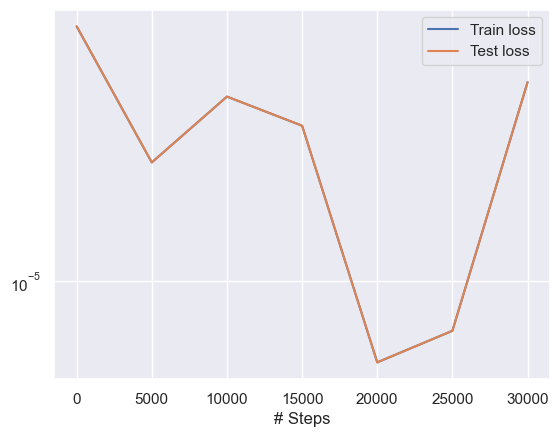

In [126]:
losshistory, train_state = model.train(iterations=30000, display_every=5000, callbacks=[variable])
dde.utils.external.plot_loss_history(losshistory)

In [129]:
lines = open("variables.dat", "r").readlines()
raw_parameters_pred_history = np.array(
    [
         np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)
iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]

parameters_pred_history = {   
    name: raw_parameters_pred_history[:, i]
    for i, name in enumerate(parameters_real.keys())
}
parameters_pred_history.keys()

dict_keys(['alpha', 'beta', 'gamma', 'delta'])

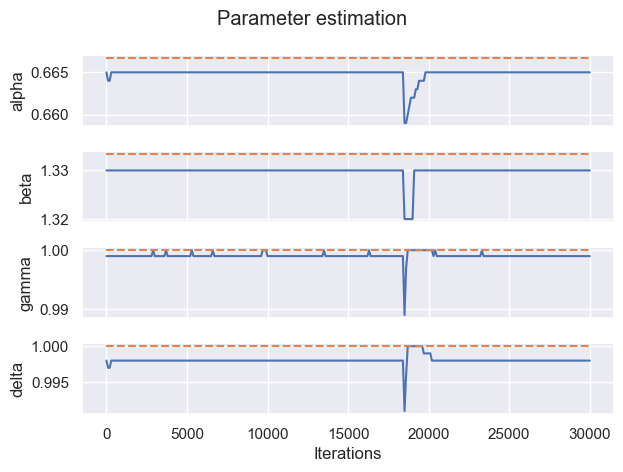

In [130]:
n_callbacis, n_variables = raw_parameters_pred_history.shape
fig, axes = plt.subplots(nrows=n_variables, sharex=True)
for ax, (parameter, parameter_value) in zip(axes, parameters_real.items()):
    ax.plot(iterations, parameters_pred_history[parameter] , "-")
    ax.plot(iterations, np.ones_like(iterations) * parameter_value, "--")
    ax.set_ylabel(parameter)
ax.set_xlabel("Iterations")
fig.suptitle("Parameter estimation")
fig.tight_layout()

In [131]:
alpha_pred, beta_pred, gamma_pred, delta_pred = variable.value

print(f"alpha - real: {alpha_real:4f} - predicted: {alpha_pred:4f} - relative error: {np.abs((alpha_real - alpha_pred) / alpha_real):4f}")
print(f"beta - real: {beta_real:4f} - predicted: {beta_pred:4f} - relative error: {np.abs((beta_real - beta_pred) / beta_real):4f}")
print(f"gamma - real: {gamma_real:4f} - predicted: {gamma_pred:4f} - relative error: {np.abs((gamma_real - gamma_pred) / gamma_real):4f}")
print(f"delta - real: {delta_real:4f} - predicted: {delta_pred:4f} - relative error: {np.abs((delta_real - delta_pred) / delta_real):4f}")

alpha - real: 0.666667 - predicted: 0.665118 - relative error: 0.002322
beta - real: 1.333333 - predicted: 1.330177 - relative error: 0.002367
gamma - real: 1.000000 - predicted: 0.999346 - relative error: 0.000654
delta - real: 1.000000 - predicted: 0.998054 - relative error: 0.001946


In [132]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
import deepxde as dde

from deepxde.backend import tf
from scipy.integrate import solve_ivp

sns.set_theme(style="darkgrid")

In [133]:
N = 1e7
S_0 = N - 1
I_0 = 1
R_0 = 0
D_0 = 0
y0 = [S_0, I_0, R_0, D_0]  # Initial conditions vector

beta = 0.5
omega = 1 / 14
gamma = 0.1 / 14

parameters_real = {
    "beta": beta,
    "omega": omega,
    "gamma": gamma,
}

In [134]:
def generate_data(
    t_array,
    y0,
):

    def func(t, y):
        S, I, R, D = y
        dS_dt = - beta * S / N * I
        dI_dt = beta * S / N * I - omega * I - gamma * I 
        dR_dt = omega * I
        dD_dt = gamma * I

        return np.array([dS_dt, dI_dt, dR_dt, dD_dt])

    t_span = (t_array[0], t_array[-1])
    sol = solve_ivp(func, t_span, y0, t_eval=t_array)
    return sol.y.T

In [135]:
n_days = 120  # 3 months
t_train = np.arange(0, n_days, 1)[:, np.newaxis]
y_train = generate_data(np.ravel(t_train), y0)
y_train.shape

(120, 4)

C:\Users\sebas\AppData\Local\Temp\ipykernel_14956\420465252.py:21: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


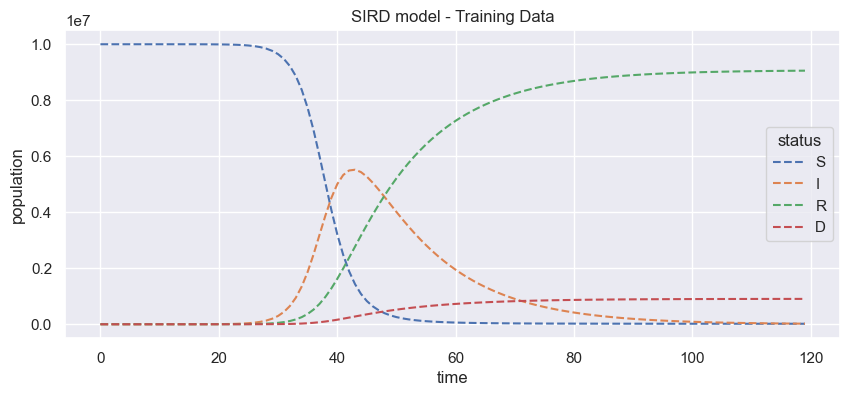

In [136]:
model_name = "SIRD"
populations_names = list(model_name)
data_real = (
        pd.DataFrame(y_train, columns=populations_names)
        .assign(time=t_train)
        .melt(id_vars="time", var_name="status", value_name="population")
)

fig, ax = plt.subplots(figsize=(10, 4))
sns.lineplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    legend=True,
    linestyle="dashed",
    ax=ax
)

ax.set_title(f"{model_name} model - Training Data")
fig.show()

In [137]:
_beta = dde.Variable(0.0)
_omega = dde.Variable(0.0)
_gamma = dde.Variable(0.0)

In [138]:
def ode(t, y):

    S = y[:, 0:1]
    I = y[:, 1:2]
    R = y[:, 2:3]
    D = y[:, 3:4]

    dS_dt = dde.grad.jacobian(y, t, i=0)
    dI_dt = dde.grad.jacobian(y, t, i=1)
    dR_dt = dde.grad.jacobian(y, t, i=2)
    dD_dt = dde.grad.jacobian(y, t, i=3)

    return [
        dS_dt - ( - _beta * S / N * I ),
        dI_dt - ( _beta * S / N * I - _omega * I - _gamma * I  ),
        dR_dt - ( _omega * I ),
        dD_dt - ( _gamma * I )
    ]

In [139]:
# Geometry
geom = dde.geometry.TimeDomain(t_train[0, 0], t_train[-1, 0])

# Boundaries
def boundary(_, on_initial):
    return on_initial

# Initial conditions
S_0, I_0, R_0, D_0 = y_train[0, :]
ic_S = dde.icbc.IC(geom, lambda x: S_0, boundary, component=0)
ic_I = dde.icbc.IC(geom, lambda x: I_0, boundary, component=1)
ic_R = dde.icbc.IC(geom, lambda x: R_0, boundary, component=2)
ic_D = dde.icbc.IC(geom, lambda x: D_0, boundary, component=3)

In [140]:
observed_S = dde.icbc.PointSetBC(t_train, y_train[:, 0:1], component=0)
observed_I = dde.icbc.PointSetBC(t_train, y_train[:, 1:2], component=1)
observed_R = dde.icbc.PointSetBC(t_train, y_train[:, 2:3], component=2)
observed_D = dde.icbc.PointSetBC(t_train, y_train[:, 3:4], component=3)

In [141]:
data = dde.data.PDE(
    geom,
    ode,
    [
        ic_S,
        ic_I,
        ic_R,
        ic_D,
        observed_S,
        observed_I,
        observed_R,
        observed_D,
    ],
    num_domain=256,
    num_boundary=2,
    anchors=t_train,
)

In [142]:
neurons = 64
layers = 3
activation = "relu"
net = dde.nn.FNN([1] + [neurons] * layers + [4], activation, "Glorot uniform")

In [146]:
variable_filename = "sird_variables.dat"
variable = dde.callbacks.VariableValue(
    [_beta, _omega, _gamma],
    period=100,
    filename=variable_filename
)

Compiling model...
'compile' took 0.000268 s

Training model...

Step      Train loss                                                                                                                  Test loss                                                                                                                   Test metric
0         [3.22e-03, 1.62e-03, 2.91e-03, 7.04e-03, 1.00e+14, 1.00e+00, 0.00e+00, 0.00e+00, 3.01e+13, 3.64e+12, 4.21e+13, 4.21e+11]    [3.22e-03, 1.62e-03, 2.91e-03, 7.04e-03, 1.00e+14, 1.00e+00, 0.00e+00, 0.00e+00, 3.01e+13, 3.64e+12, 4.21e+13, 4.21e+11]    []  
5000      [9.12e+08, 2.61e+08, 3.68e+08, 2.04e+08, 7.42e+12, 1.85e+11, 1.03e+13, 3.03e+10, 1.14e+13, 3.19e+12, 3.04e+13, 3.39e+11]    [9.12e+08, 2.61e+08, 3.68e+08, 2.04e+08, 7.42e+12, 1.85e+11, 1.03e+13, 3.03e+10, 1.14e+13, 3.19e+12, 3.04e+13, 3.39e+11]    []  
10000     [5.50e+09, 4.26e+09, 3.62e+09, 3.43e+08, 9.05e+08, 1.79e+10, 1.40e+10, 3.47e+08, 7.98e+11, 1.97e+12, 9.35e+11, 8.23e+09]    [5.50

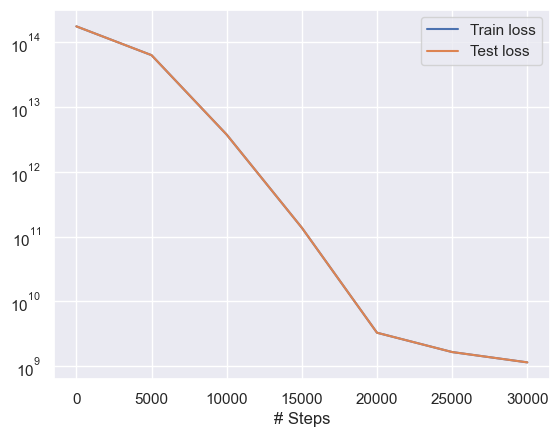

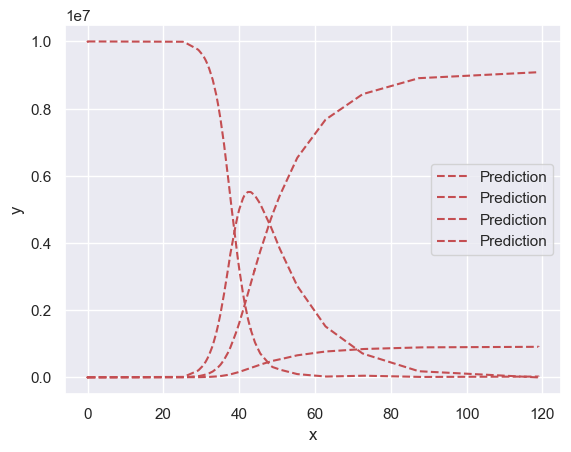

In [148]:
model = dde.Model(data, net)
model.compile(
    "adam",
    lr=1e-3,
    external_trainable_variables=[_beta, _omega, _gamma]
)
losshistory, train_state = model.train(
    iterations=30000,
    display_every=5000,
    callbacks=[variable]
)
dde.saveplot(losshistory, train_state, issave=False, isplot=True)

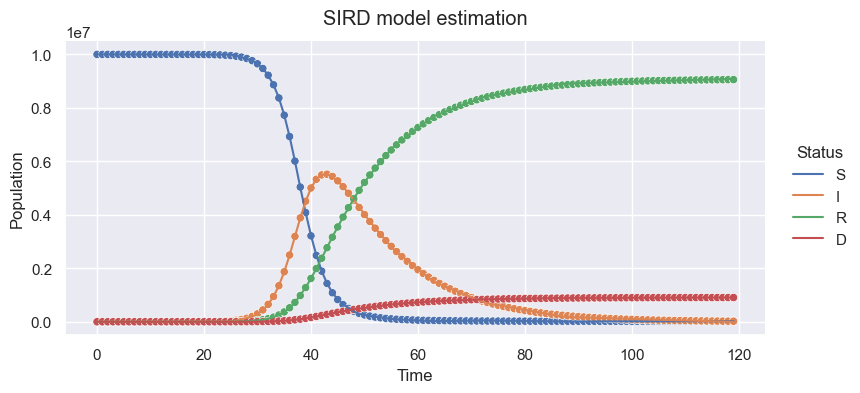

In [149]:
t_pred =  np.arange(0, n_days, 1)[:, np.newaxis]
y_pred = model.predict(t_pred)
data_pred = (
    pd.DataFrame(y_pred, columns=populations_names, index=t_pred.ravel())
    .rename_axis("time")
    .reset_index()
    .melt(id_vars="time", var_name="status", value_name="population")
)

g = sns.relplot(
    data=data_pred,
    x="time",
    y="population",
    hue="status",
    kind="line",
    aspect=2,
    height=4
)

sns.scatterplot(
    data=data_real,
    x="time",
    y="population",
    hue="status",
    ax=g.ax,
    legend=False
)

(
    g.set_axis_labels("Time", "Population")
    .tight_layout(w_pad=1)
)

g._legend.set_title("Status")
g.fig.subplots_adjust(top=0.9)
g.fig.suptitle(f"SIRD model estimation")

# plt.savefig("sird_prediction.png", dpi=300)
plt.show()

In [150]:
lines = open(variable_filename, "r").readlines()
raw_parameters_pred_history = np.array(
    [
         np.fromstring(
            min(re.findall(re.escape("[") + "(.*?)" + re.escape("]"), line), key=len),
            sep=",",
        )
        for line in lines
    ]
)

iterations = [int(re.findall("^[0-9]+", line)[0]) for line in lines]

parameters_pred_history = {   
    name: raw_parameters_pred_history[:, i]
    for i, (name, nominal) in enumerate(parameters_real.items())
}